# Image Processing

In this notebook, we are testing various ways to load and analyze the Tiff images.

## 1. Image Visualization

I didn't find any good softwares to directly view those scientific Tiff images on my laptop. I will use `tifffile` package to display them in this notebook.

Below is the simple example of loading one of those tiff images into `numpy` array and display it using `matplotlib`.

In [1]:
import math
import cv2
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

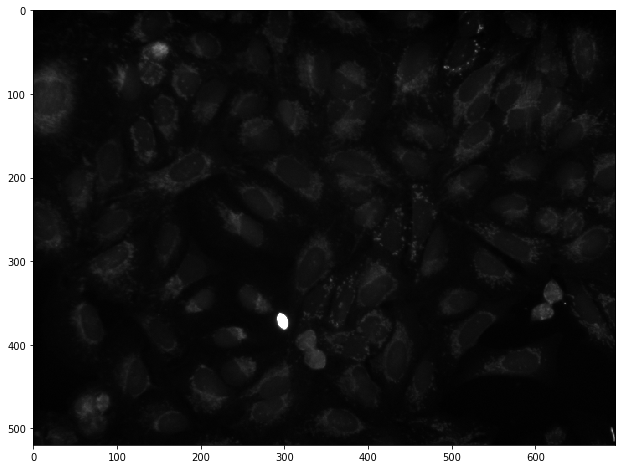

In [2]:
image = cv2.imread("data/test/test.tif", -1)
plt.figure(figsize=(16,8))
plt.imshow(image, cmap='gray')
plt.show()

In [3]:
dim = image.shape
print(dim)

(520, 696)


### 1.1. Depth of field (DOF)

For each well in the plate, there are $9$ images taken in $9$ different DOF.

In [4]:
# Load the 9 images
imgs = []
for i in range(1, 10):
    imgs.append(cv2.imread("data/test/dof/dof{}.tif".format(i), -1))

# Stack 9 images together
combi = np.vstack(
    (
        np.hstack((imgs[0], imgs[1], imgs[2])),
        np.hstack((imgs[3], imgs[4], imgs[5])),
        np.hstack((imgs[6], imgs[7], imgs[8]))
    )
)

# Draw white borders
thickness = 2
cv2.line(combi, (0, dim[0]), (dim[1]*3-1, dim[0]), 4096, thickness)
cv2.line(combi, (0, dim[0]*2-1), (dim[1]*3-1, dim[0]*2-1), 4096, thickness)
cv2.line(combi, (dim[1], 0), (dim[1], dim[0]*3-1), 4096, thickness)
cv2.line(combi, (dim[1]*2-1, 0), (dim[1]*2-1, dim[0]*3-1), 4096, thickness);

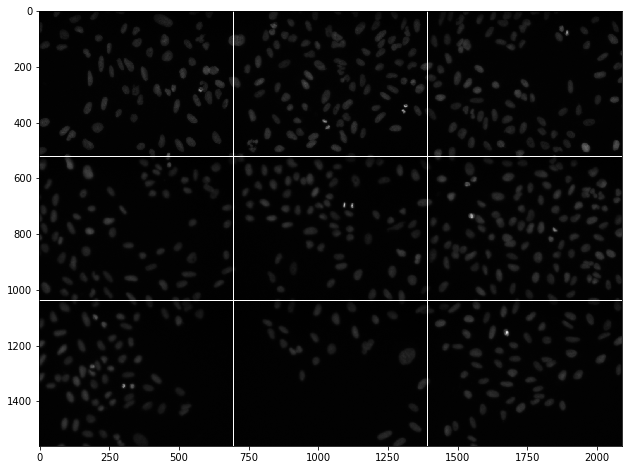

In [5]:
plt.figure(figsize=(16,8))
plt.imshow(combi, cmap='gray')
plt.show()

###  1.2. Channels

Each well image has five channels. We can try to merge some of those channels to visualize the images.

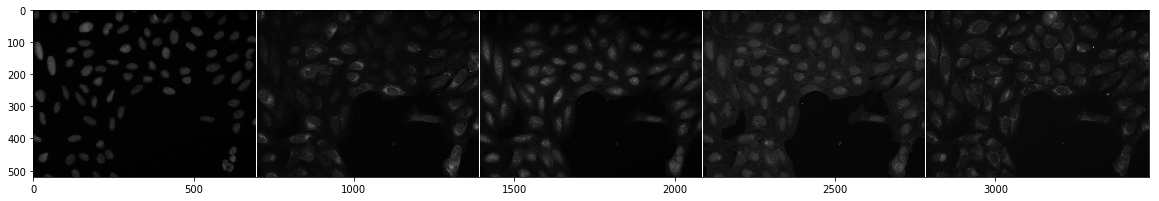

In [6]:
# Load 5 images
imgs = []
for i in range(1, 6):
    imgs.append(cv2.imread("data/test/channel/c{}.tif".format(i), -1))

height = imgs[0].shape[0]
width = imgs[0].shape[1]

# Display 5 images side by side
combi = np.hstack(imgs)

# Add white borders
for i in range(1,5):
    cv2.line(combi, (i*width, 0), (i*width, height), 4096, thickness)

plt.figure(figsize=(20,20))
plt.imshow(combi, cmap="gray")
plt.show()

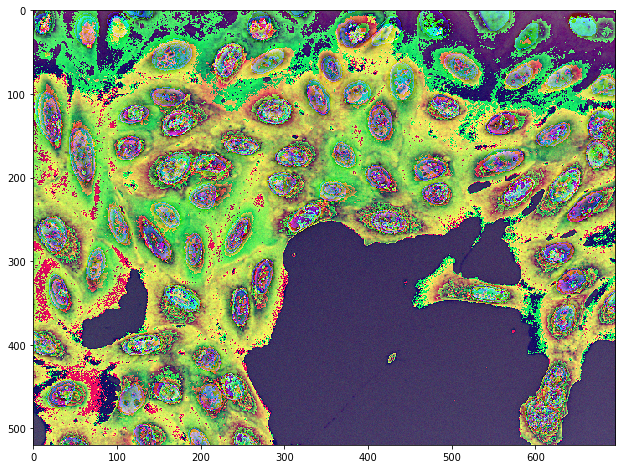

In [7]:
# Display the first three channels
# Be careful with the channel order; openCV is using BGR
merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))
merged_123_float = merged_123.astype(float)

plt.figure(figsize=(16,8))
plt.imshow(merged_123_float)
plt.show()

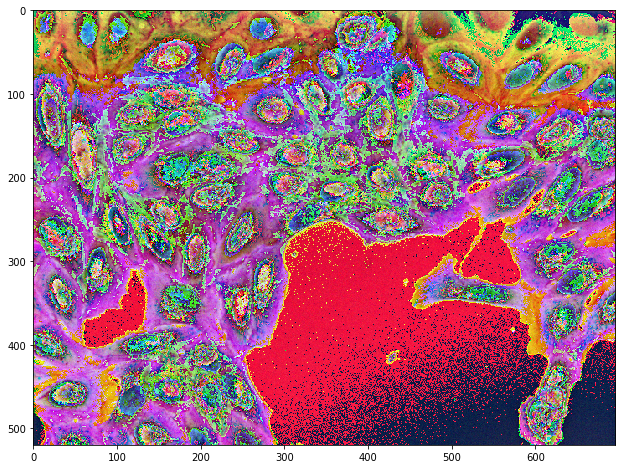

In [8]:
# Display the last three channels
merged_345 = cv2.merge((imgs[4], imgs[3], imgs[2]))
merged_345_float = merged_345.astype(float)

plt.figure(figsize=(16,8))
plt.imshow(merged_345_float)
plt.show()

## 2. Intensity Fix

I found the original intensity level of each pixel is too low for a 16-bit format image, so they show up as black pixels using the default "16-bit scale mapping". `matplotlib` changes its mapping based on the image matrix, so we can see the content.

Another probability is that Broad Institute is using a variant of 16-bit image format. Quoting from [Wikipedia](https://en.wikipedia.org/wiki/Color_depth#cite_note-7):

>In 16-bit direct color, there can be 4 bits (16 possible levels) for each of the R, G, and B components, plus optionally 4 bits for alpha (transparency), enabling 4,096 (16 × 16 × 16) different colors with 16 levels of transparency.
>
> Or in some systems there can be 5 bits per color component and 1 bit of alpha (32,768 colors, just fully transparent or not); or there can be 5 bits for red, 6 bits for green, and 5 bits for blue, for 65,536 colors with no transparency.

Based on the distribution of intensity, Broad Institute might be using the 4096 depth 16-bit format (I don't know why they need alpha channel for photography). What Photoshop does is to convert it to 65536 depth 16-bit format.

In [9]:
original = cv2.imread("./data/test/test.tif", -1)
ps_fixed = cv2.imread("./data/test/test_ps.tif", -1)
comb = np.hstack((original, ps_fixed))

In [10]:
original

array([[257, 250, 261, ..., 241, 225, 245],
       [238, 248, 247, ..., 229, 241, 228],
       [255, 243, 239, ..., 230, 235, 235],
       ...,
       [300, 310, 318, ..., 294, 277, 290],
       [317, 332, 318, ..., 280, 282, 266],
       [314, 319, 333, ..., 281, 280, 277]], dtype=uint16)

In [11]:
ps_fixed

array([[3126, 3038, 3200, ..., 2806, 2658, 2856],
       [2896, 3002, 3008, ..., 2690, 2812, 2682],
       [3064, 2946, 2912, ..., 2690, 2754, 2758],
       ...,
       [5146, 5426, 5668, ..., 4530, 4176, 4472],
       [5536, 5910, 5658, ..., 4174, 4224, 3874],
       [5442, 5634, 6012, ..., 4188, 4144, 4104]], dtype=uint16)

In [12]:
ps_fixed / original

array([[12.16342412, 12.152     , 12.2605364 , ..., 11.64315353,
        11.81333333, 11.65714286],
       [12.16806723, 12.10483871, 12.17813765, ..., 11.74672489,
        11.66804979, 11.76315789],
       [12.01568627, 12.12345679, 12.18410042, ..., 11.69565217,
        11.71914894, 11.73617021],
       ...,
       [17.15333333, 17.50322581, 17.82389937, ..., 15.40816327,
        15.07581227, 15.42068966],
       [17.4637224 , 17.80120482, 17.79245283, ..., 14.90714286,
        14.9787234 , 14.56390977],
       [17.33121019, 17.66144201, 18.05405405, ..., 14.90391459,
        14.8       , 14.81588448]])

We can see the intensity level changes after modification of Photoshop. The change is not linear, so if we decide to rescale the intensity we need to figure out how Photoshop does this.

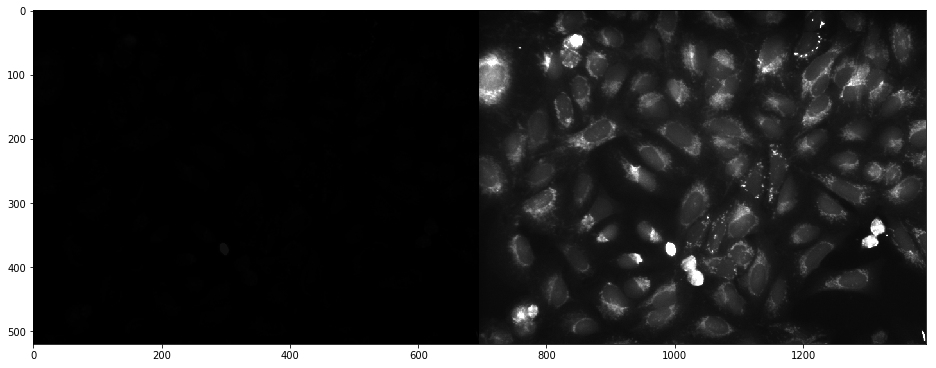

In [13]:
plt.figure(figsize=(16,8))
plt.imshow(comb, cmap='gray')
plt.show()

If we concatenate two image matrices, `matplotlib` adapts the scale of the PS fixed version so the original becomes black again (on the left).

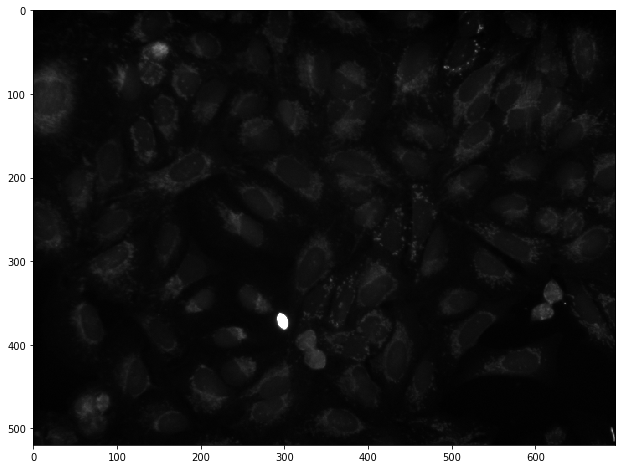

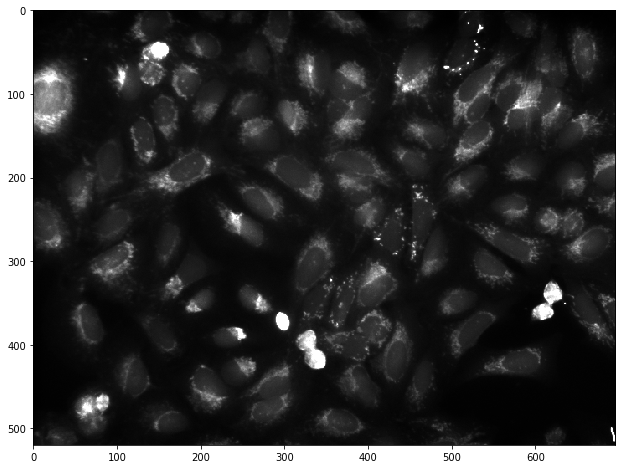

In [14]:
plt.figure(figsize=(16,8))
plt.imshow(original, cmap='gray')
plt.show()
plt.figure(figsize=(16,8))
plt.imshow(ps_fixed, cmap='gray')
plt.show()

If we plot them one by one, then we can see a difference. I believe the fixed image is more closed to the real result from Broad Institute.

If we can confirm that these images are encoded in 16-bits with 4096 color depth, then we can customize the `colormap` in `matplotlib` as below. Or we can design a way to linearly rescale 4096 depth to 65536 depth.

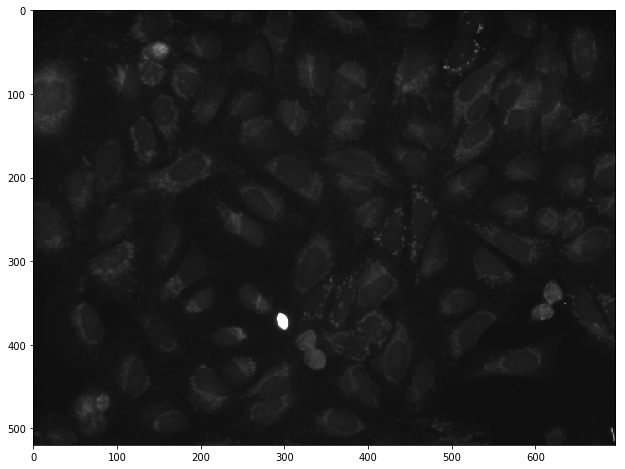

In [15]:
# Customize the colormap in matplotlib
plt.figure(figsize=(16,8))
plt.imshow(original, cmap='gray', vmin=0, vmax=4096)
plt.show()

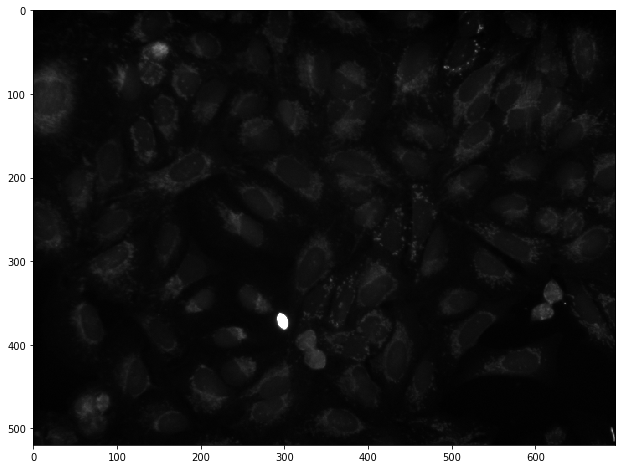

In [16]:
# Linear rescale the image from 4096 to 65536
rescaled_img = original * (65536/4096)
plt.figure(figsize=(16,8))
plt.imshow(original, cmap='gray')
plt.show()

### 2.1. Intensity fixed DOF

In [17]:
# Load the 9 images
imgs = []
for i in range(1, 10):
    imgs.append(cv2.imread("data/test/ps_fixed/dof/dof{}.tif".format(i), -1))

# Stack 9 images together
combi = np.vstack(
    (
        np.hstack((imgs[0], imgs[1], imgs[2])),
        np.hstack((imgs[3], imgs[4], imgs[5])),
        np.hstack((imgs[6], imgs[7], imgs[8]))
    )
)

# Draw white borders
thickness = 2
cv2.line(combi, (0, dim[0]), (dim[1]*3-1, dim[0]), 65536, thickness)
cv2.line(combi, (0, dim[0]*2-1), (dim[1]*3-1, dim[0]*2-1), 65536, thickness)
cv2.line(combi, (dim[1], 0), (dim[1], dim[0]*3-1), 65536, thickness)
cv2.line(combi, (dim[1]*2-1, 0), (dim[1]*2-1, dim[0]*3-1), 65536, thickness);

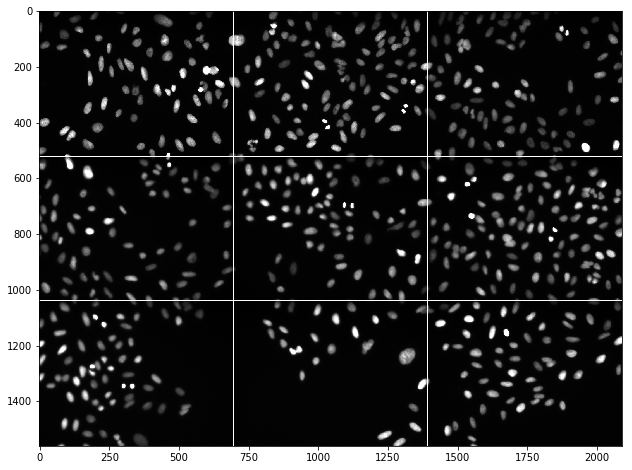

In [18]:
plt.figure(figsize=(16,8))
plt.imshow(combi, cmap='gray')
plt.show()

### 2.2. Channels

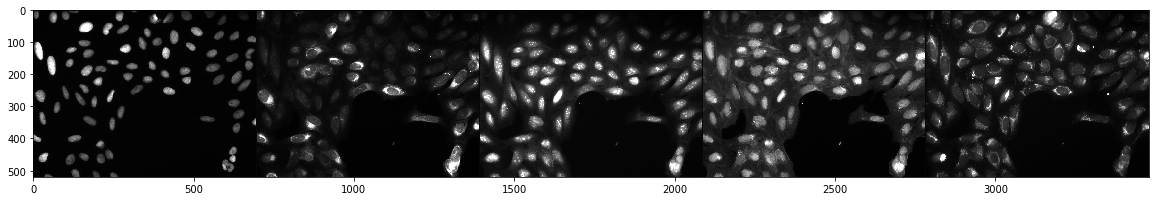

In [19]:
# Load 5 images
imgs = []
for i in range(1, 6):
    imgs.append(cv2.imread("data/test/ps_fixed/channel/c{}.tif".format(i), -1))

height = imgs[0].shape[0]
width = imgs[0].shape[1]

# Display 5 images side by side
combi = np.hstack(imgs)

# Add white borders
for i in range(1,5):
    cv2.line(combi, (i*width, 0), (i*width, height), 4096, thickness)

plt.figure(figsize=(20,20))
plt.imshow(combi, cmap="gray")
plt.show()

In [20]:
# Display the first three channels
# Be careful with the channel order: openCV is using BGR
merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))
merged_345 = cv2.merge((imgs[4], imgs[3], imgs[2]))

cv2.imwrite('./plots/c123_fixed.tif', merged_123)
cv2.imwrite('./plots/c345_fixed.tif', merged_345)

# plt.figure(figsize=(16,8))
# plt.imshow(merged_123)
# plt.show()

True

It turns out `matplotlib` only support plotting 8-bit RGB images. Therefore, I just merge those images then link them into this notebook.

One also can use `imagemagic`, a command line too for imaging, to make RGB visualizations. The result is the same as using openCV.

```shell
convert c1.tif c2.tif c3.tif -combine -set colorspace sRGB c123.tif
convert c3.tif c4.tif c5.tif -combine -set colorspace sRGB c345.tif
```

Then we get those beautiful images!

<p align="center">
    <img src="./plots/c123_fixed.tif">
    <center><em>Channel 1, 2, 3 as RGB</em></center>
</p>

<p align="center">
    <img src="./plots/c345_fixed.tif">
    <center><em>Channel 3, 4, 5 as RGB</em></center>
</p>

### 2.3. Revisit the original channels

Before fixing each channels, we have saved the merged image in the original format. As expected, they are all black. Let's see if we linearly rescale the 4096 intensity to 65536 (by multiplying 16).

In [21]:
imgs = []
for i in range(1, 6):
    imgs.append(cv2.imread("data/test/channel/c{}.tif".format(i), -1) * 16)

merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))
merged_345 = cv2.merge((imgs[4], imgs[3], imgs[2]))

cv2.imwrite("./plots/c123_ln_fixed.tif", merged_123)
cv2.imwrite("./plots/c345_ln_fixed.tif", merged_345)

True

<p align="center">
    <img src="./plots/c123_ln_fixed.tif">
    <center><em>Channel 1, 2, 3 as RGB</em></center>
</p>

<p align="center">
    <img src="./plots/c345_ln_fixed.tif">
    <center><em>Channel 3, 4, 5 as RGB</em></center>
</p>

Comparing to fixing using PS, linear rescale gives a dimmer and less saturated image.

## 3. Single Cell Cropping

In [meta_data.ipynb](./meta_data.ipynb), we found a way to use features in the sql database to crop single cell images. We can try it in this section.

In [22]:
# Get the location features
conn = sqlite3.connect('./data/test/meta_data/extracted_features/24278.sqlite')
c = conn.cursor()

# Get the second combined key
c.execute(
    """
    SELECT TableNumber, ImageNumber
    FROM Image
    WHERE Image_Metadata_Plate = 24278 AND Image_Metadata_Site = '1' AND Image_Metadata_Well = 'a01'
    """
)
result = c.fetchall()
tid, iid = result[0]

# Query in Cells table

c.execute(
    """
    SELECT Cells_AreaShape_Center_X, Cells_AreaShape_Center_Y, Cells_AreaShape_MajorAxisLength,
        Cells_AreaShape_MinorAxisLength, Cells_AreaShape_MaximumRadius, Cells_AreaShape_Orientation
    FROM Cells
    WHERE TableNumber = '{}' AND ImageNumber = {} AND ObjectNumber BETWEEN {} AND {};
    """.format(tid, iid, 1, 58)
)

result = c.fetchall()
df = pd.DataFrame(np.array(result),
                  columns=["CenterX", "CenterY", "MajorAxisLength",
                           "MinorAxisLength", "MaximumRadius", "Orientation"])
df.head()

CenterX  CenterY  MajorAxisLength  MinorAxisLength  MaximumRadius  \
0     43.0      0.0        70.397234        36.222035      21.023796   
1    619.0     28.0        97.565456        42.534725      20.000000   
2    219.0     33.0        68.268046        49.118568      20.615528   
3    265.0     32.0        75.198694        34.684289      17.691806   
4     82.0     11.0        54.504681        40.508727      18.681542   

   Orientation  
0    63.738571  
1   -34.521891  
2   -73.795204  
3   -28.019719  
4   -70.130892

### 3.1. Circle Cropping

Using the feature `Cells_AreaShape_Center_X`, `Cells_AreaShape_Center_Y`, `Cells_AreaShape_MaximumRadius`, we can bound cells into circles. I can't find a way to plot 16-bit RGB image in Jupyter yet, so I will link the local file to this notebook.

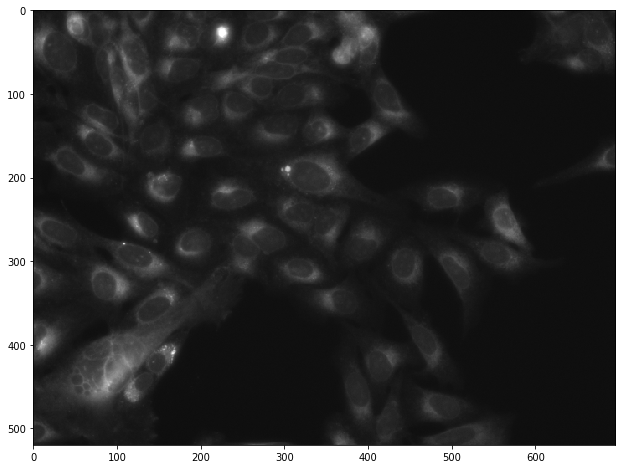

In [23]:
image = cv2.imread("data/test/meta_data/c1.tif", -1)
plt.figure(figsize=(16,8))
plt.imshow(image, cmap='gray', vmin=0, vmax=4096)
plt.show()

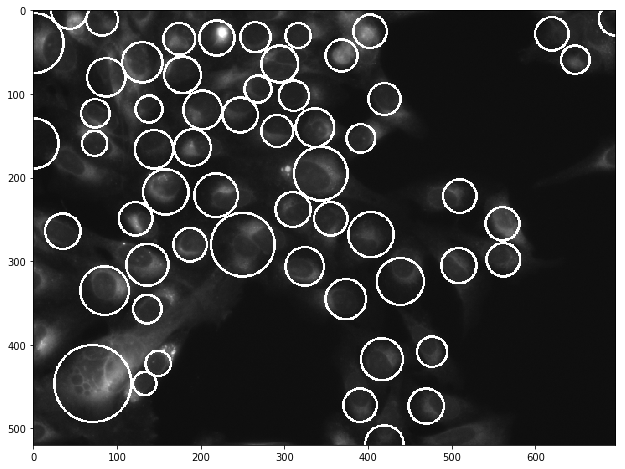

In [24]:
# Add circles
for r in result:
    cv2.circle(image, (int(r[0]), int(r[1])), math.ceil(r[4]), 4096, thickness=2)

plt.figure(figsize=(16,8))
plt.imshow(image, cmap='gray', vmin=0, vmax=4096)
plt.show()

In [25]:
imgs = []
for i in range(1, 6):
    imgs.append(cv2.imread("data/test/meta_data/c{}.tif".format(i), -1) * 16)

merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))

for r in result:
    cv2.circle(merged_123, (int(r[0]), int(r[1])), math.ceil(r[4]), (65536, 65536, 65536), thickness=2)

cv2.imwrite('./plots/circle_crop.tif', merged_123)

True

<img src="./plots/circle_crop.tif">

I guess their algorithm was to avoid overlay, so the bounding circle does not bound the whole cell.

### 3.2. Rectangle Cropping

Using the feature `Cells_AreaShape_Center_X`, `Cells_AreaShape_Center_Y`, `Cells_AreaShape_MajorAxisLength`, `Cells_AreaShape_MinorAxisLength` and `Cells_AreaShape_Orientation`, we can bound cells into rectangles.

In [26]:
print(max(df['Orientation']), min(df['Orientation']))

81.8747163653893 -88.34033809085989


To draw the rectangles, we can model angled (with orientation) rectangles as polygon in openCV.

**The orientation of `Cells_AreaShape_Orientation` is opposite from openCV.**

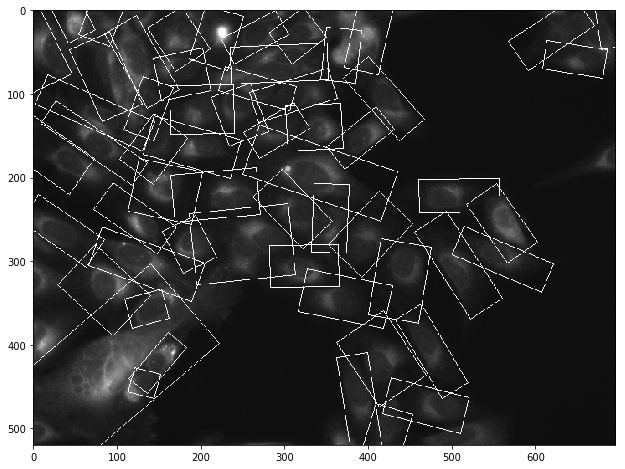

In [27]:
image = cv2.imread("data/test/meta_data/c1.tif", -1)

for r in result:
    # Load information
    degree = r[5]
    x, y = r[0], r[1]
    half_major, half_minor = int(r[2]/2), int(r[3]/2)

    # Create vertexes
    points = np.array([[
        [x - half_major, y - half_minor],
        [x + half_major, y - half_minor],
        [x + half_major, y + half_minor],
        [x - half_major, y + half_minor]
    ]])

    # Rotate all the vertxes around the center point
    rotate_matrix = cv2.getRotationMatrix2D((x, y), -degree, 1)
    rotated_points = cv2.transform(points, rotate_matrix)[0]

    # Format the points and draw them
    points = rotated_points.astype(int).reshape((-1,1,2))
    cv2.polylines(image, [points], True, 4096, thickness=1)

plt.figure(figsize=(16,8))
plt.imshow(image, cmap='gray', vmin=0, vmax=4096)
plt.show()

In [28]:
# Visualize it in muli-channel

imgs = []
for i in range(1, 6):
    imgs.append(cv2.imread("data/test/meta_data/c{}.tif".format(i), -1) * 16)

merged_123 = cv2.merge((imgs[2], imgs[1], imgs[0]))

for r in result:
    # Load information
    degree = r[5]
    x, y = r[0], r[1]
    half_major, half_minor = int(r[2]/2), int(r[3]/2)

    # Create vertexes
    points = np.array([[
        [x - half_major, y - half_minor],
        [x + half_major, y - half_minor],
        [x + half_major, y + half_minor],
        [x - half_major, y + half_minor]
    ]])

    # Rotate all the vertxes around the center point
    rotate_matrix = cv2.getRotationMatrix2D((x, y), -degree, 1)
    rotated_points = cv2.transform(points, rotate_matrix)[0]

    # Format the points and draw them
    points = rotated_points.astype(int).reshape((-1,1,2))
    cv2.polylines(merged_123, [points], True, (65536, 65536, 65536), thickness=1)

cv2.imwrite('./plots/rec_crop.tif', merged_123)

True

The result looks quite nice! It may save us tons of times for cropping images. 🎉

<img src="./plots/rec_crop.tif">